[![badge](https://img.shields.io/badge/launch-notebook-E66581.svg?logo=)](https://mybinder.org/v2/gl/nu-data-insights%2Fquantum/HEAD?filepath=docs%2Fscc-problem.ipynb)

In this workbook we'll see how hybrid quantum machine learning is used to learn two unknown parameters in an quantum algorithmn. 

First we have to import all the useful tools that will be used...

In [1]:
import cirq
from cirq.contrib.svg import SVGCircuit

import tensorflow as tf
import tensorflow_quantum as tfq

import numpy as np
import sympy as sp

import pandas as pd

import matplotlib.pyplot as plt
plt.rc('font', size=12)         
plt.rc('axes', titlesize=12)    
plt.rc('axes', labelsize=12)    
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)   
plt.rc('legend', fontsize=12)   
plt.rc('figure', titlesize=12)  

In the [previous notebook](/scc-intro) we saw how two qubits, could represent the conciousness of cats. We can now add two phase gates, as inputs to the circuit, which can control what the initial state of the qubit, since previously we have always dealth with the gates being in the pure state of $|0\rangle$. 


## Cat Algoirthmn

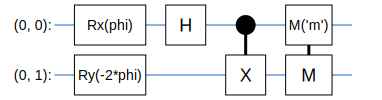

In [2]:
q0  = cirq.GridQubit(0,0)
q1  = cirq.GridQubit(0,1)
phi = sp.Symbol('phi')


circuit = cirq.Circuit([
                cirq.rx(phi)(q0),
                cirq.ry(-2*phi)(q1),
                cirq.H(q0),
                cirq.CNOT(q0,q1),
                cirq.measure(q0,q1,key='m')
                ])
SVGCircuit(circuit)

### Basic algorithmns

This is not exactly a quantum algorithmn but it should start to show you how to deal with quantum bits (qubits) and the power of entangling them.

#### Simple two qubit system

Next we can perform a sweep over the parameter $\phi$ for 5 values between 0 and 1

In [3]:
sweep = cirq.Linspace("phi", start=0.0, stop=np.pi/2, length=5)

We can run a sweep of the simulator with these sweep parameters to simulate what 1000 results for each value of $\phi$ will give:

In [4]:
simulator = cirq.Simulator()
results = simulator.run_sweep(circuit, sweep, repetitions=1000)

From plotting the results we can see how changing the value of $\phi$ is affecting the observations of the cats being either awake or asleep.

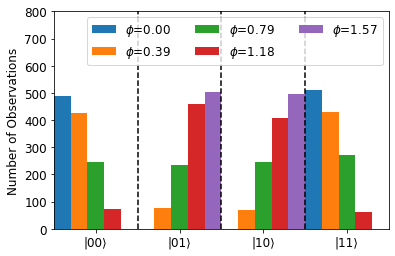

In [5]:
width = 0.2
fig,ax = plt.subplots(1)

for ii,result in enumerate(results):
    phi = result.params['phi']

    x = np.array([ i for i in range(4) ])
    y = np.array([result.histogram(key='m')[i] for i in range(len(x)) ])
    
    ax.bar(x+ii*width,y,width,label='$\phi$=%.2f'%(phi))
    
ax.set_xticks(x+2*width)
ax.set_xticklabels( ['|00⟩','|01⟩','|10⟩','|11⟩']  )
ax.set_ylabel('Number of Observations')
for xx in [1,2,3]:
    ax.axvline(xx-width*0.5,color='black',linestyle='--')

ax.legend(ncol=3)
ax.set_ylim(0,800)
ax.set_xlim(-0.1,3.9)
plt.show();

Another way of looking at this is to plot how the states change by varying the parameter $\phi$ from [$-\pi$ , $\pi$]

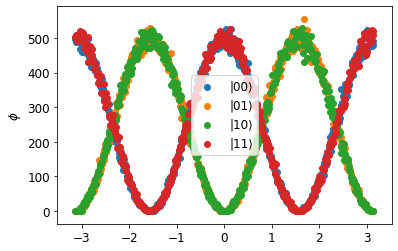

In [6]:
sweep = cirq.Linspace("phi", start=-1*np.pi, stop=np.pi, length=500)
results = simulator.run_sweep(circuit, sweep, repetitions=1000)

fig,ax = plt.subplots(1)

x = [result.params['phi'] for result in results]
for i,label in enumerate(['|00⟩','|01⟩','|10⟩','|11⟩']):
    y = [result.histogram(key='m')[i] for result in results]
    ax.scatter(x,y,label=label)
    
ax.set_ylabel('Number of Observations')
ax.set_ylabel('$\phi$')
    
ax.legend()
plt.show()

this is showing how the amount of entanglement between the states can be some-what {++controlled++}. 

The plots show how for a values of $\phi = \{-\pi, 0 , \pi\}$ we get the entanglement as before. Yet for values of $\phi = \{{\frac{-\pi}{2}, \frac{\pi}{2} \}$ we have the opposite entanglement: if the first cat is observed to be awake(asleep) the second cat must be observed to be asleep(awake).

#### Moving to four qubits

We now move to an example where we have four qubits (we can keep up the thought that each qubit represents the conciousness of four different cats)

This example shows how we can play with entangling different qubits and also introducing the CCX gate.

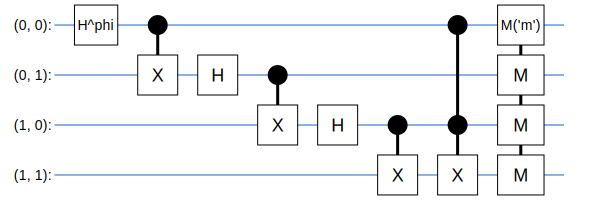

In [7]:
q0  = cirq.GridQubit(0,0)
q1  = cirq.GridQubit(0,1)
q2  = cirq.GridQubit(1,0)
q3  = cirq.GridQubit(1,1)

phi = sp.Symbol('phi')

circuit = cirq.Circuit([
                cirq.H(q0)**(phi),
                cirq.CNOT(q0,q1),
                cirq.H(q1),
                cirq.CNOT(q1,q2),
                cirq.H(q2),
                cirq.CNOT(q2,q3),
                cirq.CCX(q0,q2,q3),
                cirq.measure(q0,q1,q2,q3,key='m')
                ])
SVGCircuit(circuit)

!!! note Use a little python trick to get all the qubit states that are possible with 4 bits. 
    E.g. $|1001\rangle$ means the 1st and 4th cat are asleep, the 2nd and 3rd are awake.

In [8]:
import itertools

x = np.array([ '|%s⟩'%(''.join([str(xx) for xx in x])) for x in itertools.product([0, 1], repeat=4) ])
x

array(['|0000⟩', '|0001⟩', '|0010⟩', '|0011⟩', '|0100⟩', '|0101⟩',
       '|0110⟩', '|0111⟩', '|1000⟩', '|1001⟩', '|1010⟩', '|1011⟩',
       '|1100⟩', '|1101⟩', '|1110⟩', '|1111⟩'], dtype='<U6')

Setup a scan over four different (arbitrary) chosen values of $\phi$ 

In [9]:
resolver_list = [
                  cirq.ParamResolver({"phi":i}) for i in [0,0.1,0.25,1,1.66]
                ]
        
sweep = cirq.ListSweep(resolver_list)

Obtain the results and, as before, plot to see what they look like

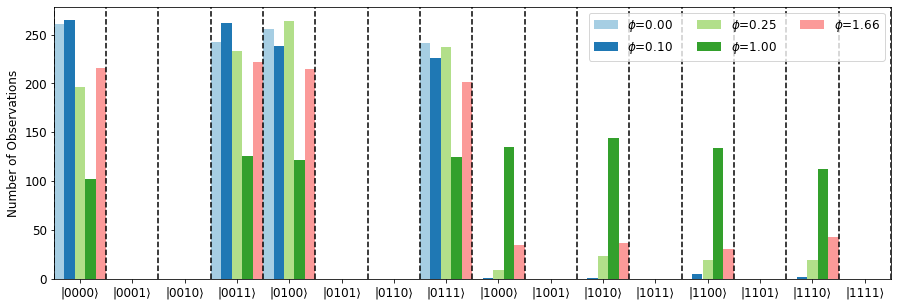

In [10]:
results = simulator.run_sweep(circuit, sweep, repetitions=1000)

width = 0.2 
cmap=plt.get_cmap('Paired')
fig,ax = plt.subplots(1,figsize=(15,5))

xx = np.array([ i for i in range(len(x)+1) ])

for ii,result in enumerate(results):
    phi = result.params['phi']

    y = np.array([result.histogram(key='m')[i] for i in xx ])
    ax.bar(xx+ii*width,y,width,label='$\phi$=%.2f'%(phi), color=cmap(ii))
    
ax.set_xticks(xx+2*width)
ax.set_xticklabels( x  )
ax.set_ylabel('Number of Observations')
for i in xx:
    ax.axvline(i-width*0.5,color='black',linestyle='--')

ax.legend(ncol=3)
ax.set_xlim(-0.1,xx[-1]-0.1)
plt.show();

As can be seen from this random setup, we are able to tune the $\phi$ value to alter the probability of observing the four cats in the different states. {==Note that there are impossible states to observe, due to the how the circuit has been setup==}. 


## Hybrid Quantum Machine Learning

In this section we jump straight into seeing how to learn to control a two-qubit system given an imperfect quantum device.

The setup goes as follows:
* We have a device that takes two qubits (representing cats) and entangles them 
* A random phase is also introduced in the circuit, due to noise/an imperfection

### Obtaining the data to learn

Firstly, let's get the data that the company have observed from running their device on these two cats..

#### Creating the device
The device setup goes as follows:

In [11]:
q0 = cirq.GridQubit(0,0)
q1 = cirq.GridQubit(0,1)

phi_0 = sp.Symbol('phi_0')
phi_1 = sp.Symbol('phi_1')
alpha = sp.Symbol('alpha')
beta = sp.Symbol('beta')

circuit = cirq.Circuit([
                cirq.rx(phi_0)(q0),
                cirq.ry(phi_1)(q1),
                cirq.H(q0),
                cirq.CNOT(q0,q1),
                cirq.rx(alpha)(q0),
                cirq.ry(beta)(q1),
                ])
SVGCircuit(circuit)

Here, $\phi_{0,1}$ are values that can be controlled as inputs to the device. $\alpha$ and $\beta$ are the random phases that are introduced.

We'll setup the circuit by creating the random values ($[-\pi,\pi]$) of $\alpha$ and $\beta$ now:

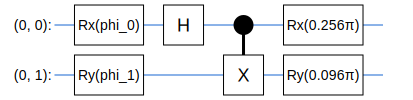

In [109]:
random_alpha, random_beta = np.random.uniform(-np.pi,np.pi,2)

circuit = cirq.Circuit([
                cirq.rx(phi_0)(q0),
                cirq.ry(phi_1)(q1),
                cirq.H(q0),
                cirq.CNOT(q0,q1),
                cirq.rx(random_alpha)(q0),
                cirq.ry(random_beta)(q1),
                ])
SVGCircuit(circuit)

The values of $\alpha$ and $\beta$ are:

In [110]:
random_alpha,random_beta

(0.8032055201586581, 0.3027485019213625)

The aim of this example is that we don't know their values, and need to learn what they are.

#### Simulating the device

In [111]:
circuit.append(cirq.measure(q0,q1,key='m'))

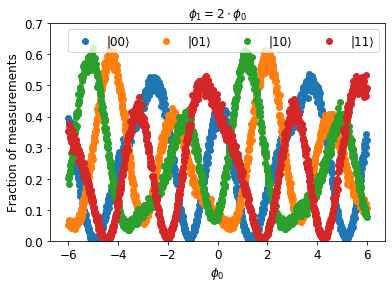

In [112]:
x = np.arange(-6,6,0.01)
states = ['|00⟩','|01⟩','|10⟩','|11⟩'] 
y = []

resolver_list = []
for phi in x:
    resolver = cirq.ParamResolver({'phi_0':phi,'phi_1':-2*phi})
    resolver_list.append(resolver)

results = simulator.run_sweep(circuit, cirq.ListSweep(resolver_list), repetitions=1000)

for i,state in enumerate(states):
    plt.scatter(x, [y.histogram(key='m')[i]/1000 for y in results],label=state)


plt.xlabel('$\phi_0$ ')
plt.ylabel('Fraction of measurements')
plt.title('$\phi_1 = 2\cdot \phi_0$')
plt.ylim(0,0.7)
plt.legend(ncol=4);
plt.show();

Trying out another example for scanning $\phi_0 \in [-\pi,\pi]$ with $\phi_1 =  \phi_0^2$, we instead get this output data:

In [113]:
x = np.arange(-np.pi,np.pi,0.01)
states = ['|00⟩','|01⟩','|10⟩','|11⟩'] 
y = []

resolver_list = []
for phi in x:
    resolver = cirq.ParamResolver({'phi_0':phi,'phi_1':phi*phi})
    resolver_list.append(resolver)

results = simulator.run_sweep(circuit, cirq.ListSweep(resolver_list), repetitions=1000)

for i,state in enumerate(states):
    plt.scatter(x, [y.histogram(key='m')[i]/1000 for y in results],label=state)


plt.xlabel('$\phi_0$')
plt.ylabel('Fraction of measurements')
plt.title('$\phi_1 = \phi_0^2$')
plt.ylim(0,0.8)
plt.legend(ncol=4);
plt.show();

The data observed is recorded and put into a pandas dataframe for storage

In [114]:
y = { state: [
                res.histogram(key='m')[i]  
                for res in results
             ] 
     for i,state in enumerate(states)
    }

df = pd.DataFrame.from_dict({**{'phi_0':x,'phi_1':x*x, **y} })
df

phi_0     phi_1  |00⟩  |01⟩  |10⟩  |11⟩
0   -3.141593  9.869604   145   384   398    73
1   -3.131593  9.806873   125   355   432    88
2   -3.121593  9.744341   133   379   421    67
3   -3.111593  9.682009   113   395   421    71
4   -3.101593  9.619877    93   405   429    73
..        ...       ...   ...   ...   ...   ...
624  3.098407  9.600128    98   432   403    67
625  3.108407  9.662196   116   385   434    65
626  3.118407  9.724464   119   398   421    62
627  3.128407  9.786933   127   359   431    83
628  3.138407  9.849601   121   372   435    72

[629 rows x 6 columns]

Finally we record the data to a `pickle` file, but we could have chosen from multiple output formats or databases.

In [115]:
df.to_pickle('dataset.pickle')

### Fitting The Circuit

Now, we pretend we do not know the random values of $\alpha$ and $\beta$, all we know is the architecture of the circuit, and the input qubit values that have produced the dataset.

So we open back up the dataset from the saved file:

In [116]:
input_data = pd.read_pickle('dataset.pickle')
input_data.sample(5)

phi_0     phi_1  |00⟩  |01⟩  |10⟩  |11⟩
219 -0.951593  0.905529   221    38   149   592
152 -1.621593  2.629563    36   274   406   284
556  2.418407  5.848694   343    58   217   382
282 -0.321593  0.103422   442    68    59   431
133 -1.811593  3.281868   172   377   342   109

#### Setting up TensorFlow Quantum

The next step is to load up the Quantum extension to TensorFlow that will be used to convert the circuits into Tensors.

In [117]:
import tensorflow as tf
import tensorflow_quantum as tfq
tf.__version__,tfq.__version__

('2.3.1', '0.5.0')

#### Setting up measurements

After resetting the qubits:

In [118]:
q0 = cirq.GridQubit(0,0)
q1 = cirq.GridQubit(0,1)

Make a PauliSum gate (`z00`) that will return `1` if the state is a pure $|00\rangle$. This is used to return the {==expectation value==} (probability) of making a measurement of $|00\rangle$.

In [119]:
z0 = cirq.Z(q0)
z1 = cirq.Z(q1)
z00 = (((1+z0)/2)*((1+z1)/2) )
z00.matrix()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

We can also make expectation measurements for the other qubit options

In [120]:
z01 = (((1+z0)/2)*((1-z1)/2) )
z10 = (((1-z0)/2)*((1+z1)/2) )
z11 = (((1-z0)/2)*((1-z1)/2) )

#### Decoupling the Circuit

To be able to train the circuit we have to decouple the circuit into two parts:


!!! note 
    With $\phi = \phi_0$ and $\phi_1 = \phi_0^2$

1. The input qubits:  
   *  1st qubit (`q0`) starts in the state $R_x(\phi)|0\rangle$ 
   *  2nd qubit (`q1`) starts in the state $R_y(\phi^2)|0\rangle$

In [121]:
phi = sp.Symbol('phi')

input_circuit = cirq.Circuit([
                cirq.rx(phi)(q0),
                cirq.ry(phi*phi)(q1)
                ])
input_circuit

(0, 0): ───Rx(phi)──────

(0, 1): ───Ry(phi**2)───

2. The model circuit 
   * `q0` and `q1` are entangled
   * $R_x(\alpha)$ is applied to the 1st qubit
   * $R_y(\beta)$ is applied to the 2nd qubit

In [122]:
alpha = sp.Symbol('alpha')
beta = sp.Symbol('beta')
model_circuit = cirq.Circuit([
                cirq.H(q0),
                cirq.CNOT(q0,q1),
                cirq.rx(alpha)(q0),
                cirq.ry(beta)(q1),
              ])


SVGCircuit(model_circuit)

#### Building a simple keras model
* input is the `input_circuit` which is the input qubits 
* PQC outputs the expectation to be in state |00> from the model circuit, given the input circuit

!!! note
    `PQC` is a TensorFlow Quantum Parameterised Quantum Circuit. It comes in the form of a `tensorflow` layer that can be plugged into ML models. It is enable to encode that there are variables ($\alpha$ and $\beta$) in the circuit that can be learnt about
    
    
Setup a simple `keras` model, and print to show there are two variables ($\alpha$ and $\beta$) that are {++trainable++}:

In [123]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, [z00]),
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_4 (PQC)                  (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


The input circuits need to be converted into `tensor` objects that can past into `tensorflow` and the `keras` backend. 

In [124]:
input_circuits =  tfq.convert_to_tensor([
                                        cirq.resolve_parameters(input_circuit, cirq.ParamResolver({'phi':x}))
                                        ] for x in input_data['phi_0'])

#### Testing the Keras Model

Now we test the model, which out of the box will have random values for $\alpha$ and $\beta$:

In [125]:
model.get_weights()

[array([1.7101309, 5.635485 ], dtype=float32)]

Get the prediciton based on these initial guesses

In [126]:
y_test = model([input_circuits]).numpy()

Convert the input data from number of observed in each state to a fraction (probability), since we know there were `1000` simulations, dividing by this number will give us data to compare with the expectation values.

In [127]:
y_observed = input_data['|00⟩'].to_numpy()/1000

Plot how a randomly initiated model compares with the observed dataset for $|00\rangle$

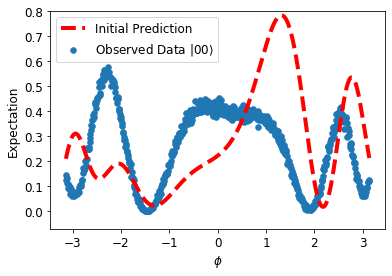

In [128]:
plt.scatter(input_data['phi_0'],y_observed,lw=0.5,label=f'Observed Data $|00\\rangle$')
plt.plot(input_data['phi_0'],y_test,'r--', lw=4,label='Initial Prediction')
plt.xlabel('$\phi$')
plt.ylabel('Expectation')
plt.ylim(-0.07,0.8)
plt.legend()
plt.show();

#### Fitting the Keras Model

Using the Adam optimiser (another arbitrary choice) we can setup to fit the model to minimise the mean squared error, a very simple regression problem.

In [129]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

This will not take many iterations to converge and find the correct values of alpha and beta.

In [130]:
history = model.fit(
      input_circuits, y_observed,
      epochs=30,
      verbose=0)
plt.plot(history.history['loss'])
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

#### Viewing the fitted model

We again plot the model prediction of the state $|00\rangle$, after the fit to see that it has learnt the correct values of $\alpha$ and $\beta$ and the prediction matches the observed well.

In [131]:
y_fitted = model([input_circuits]).numpy()
plt.scatter(input_data['phi_0'],y_observed,lw=0.5,label=f'Observed Data $|00\\rangle$')
plt.plot(input_data['phi_0'],y_fitted,'r--', lw=4,label='Post-fit Prediction')
plt.xlabel('$\phi$')
plt.ylabel('Expectation')
plt.ylim(-0.07,0.8)
plt.legend()
plt.show();

Obtaining the values of $\alpha$ and $\beta$ post-fit:

In [134]:
fitted_alpha,fitted_beta = model.get_weights()[0]
fitted_alpha,fitted_beta

(0.80749726, 6.5819235)

It can be seen how well they compare with the random true values:

In [133]:
random_alpha,random_beta

(0.8032055201586581, 0.3027485019213625)

In the example we produced we see that the fitted value of $\beta$ does not match true value of $\beta$. 

!!! question "How is this possible?"
        This occurs because of the usage of the `R_i` gates, which are {==phase-gates==} . There is an inherent $2\pi$ phase due to the nature of expotentials of the unitary logic gates.
        
        $$
        R_X(\phi) = \exp(-i X \phi / 2) = \cos(\phi/2) I - i \sin(\phi/2) X
        $$

        $$
        R_Y(\phi) = \exp(-i Y \phi / 2) = \cos(\phi/2) I - i \sin(\phi/2) Y
        $$


Taking this cyclic  into account the fitted value can be seen to be much closer to the true value

In [139]:
(fitted_beta) % (2 * np.pi), (random_beta) % (2 * np.pi)

(0.29873817762265986, 0.3027485019213625)

It would be easy to force a requirement on the values to be within $[-\pi,\pi]$ or $[0,2\pi]$, however it makes no difference.



### Learning to Control the Circuit

Now that we were able to convert the 
